In [31]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# If your notebook is in model/notebooks
REPO_ROOT = Path.cwd().parent.parent
BACKEND_DIR = REPO_ROOT / "backend"
sys.path.insert(0, str(BACKEND_DIR))


Fetching data for NVDA...


[*********************100%***********************]  1 of 1 completed


Loaded 262 rows. Latest date: 2026-02-23 00:00:00
Data type of prices: <class 'pandas.Series'>


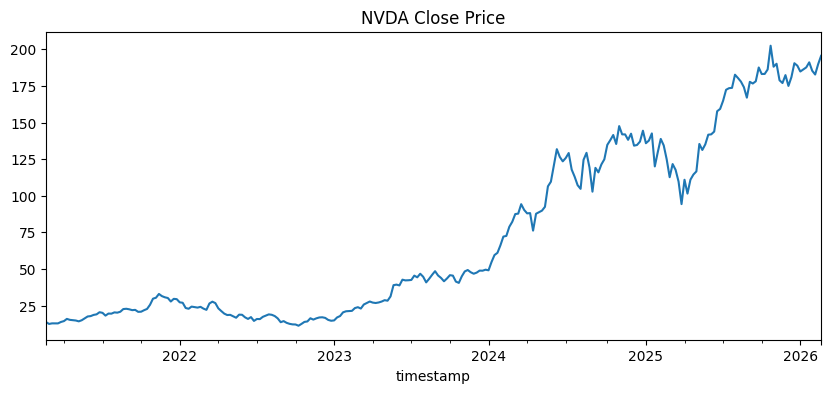

In [32]:
SYMBOL = "NVDA"
INTERVAL = "1wk"
PERIOD = "5y"

print(f"Fetching data for {SYMBOL}...")

df = yf.download(tickers=SYMBOL, period=PERIOD, interval=INTERVAL, multi_level_index=False)

df = df.reset_index().rename(columns={"Date": "timestamp", "Close": "close"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

prices = df.set_index("timestamp")["close"].astype(float).dropna()

print(f"Loaded {len(prices)} rows. Latest date: {prices.index.max()}")
print(f"Data type of prices: {type(prices)}") # Verified as <class 'pandas.core.series.Series'>
prices.head()

prices.plot(title=f"{SYMBOL} Close Price", figsize=(10,4))
plt.show()

In [33]:
# Use same feature set as 03-prophet ensemble (price_lag_1..3, vix_lag_1) for comparability.
# Note: XGB hyperparameters below were tuned for a different feature set; consider re-running
# tuning (RERUN_XGB_TUNING=True) when using this feature set for a fair comparison.
VIX_SYMBOL = "^VIX"
PRICE_LAGS = 3  # Same as 03-prophet

# Load VIX and align to price dates
vix_df = yf.download(tickers=VIX_SYMBOL, period=PERIOD, interval=INTERVAL, multi_level_index=False)
vix_df = vix_df.reset_index().rename(columns={"Date": "timestamp", "Close": "vix"})
vix_df["timestamp"] = pd.to_datetime(vix_df["timestamp"])
vix = vix_df.set_index("timestamp")["vix"].astype(float).reindex(prices.index).ffill().bfill()

# Build feature frame: close, vix, price lags, vix lag (same as 03-prophet XGB features, without residual)
feat = pd.DataFrame({"close": prices, "vix": vix}, index=prices.index)
for lag in range(1, PRICE_LAGS + 1):
    feat[f"price_lag_{lag}"] = feat["close"].shift(lag)
feat["vix_lag_1"] = feat["vix"].shift(1)
feat["y_next"] = feat["close"].shift(-1)
model_df = feat.dropna().copy()

feature_cols = [c for c in model_df.columns if c.startswith("price_lag_")] + ["vix_lag_1"]

model_df[feature_cols + ["y_next"]].head(), model_df.shape

[*********************100%***********************]  1 of 1 completed


(            price_lag_1  price_lag_2  price_lag_3  vix_lag_1     y_next
 timestamp                                                              
 2021-03-15    12.819947    12.426555    13.676039  20.690001  12.807663
 2021-03-22    12.814150    12.819947    12.426555  20.950001  13.777771
 2021-03-29    12.807663    12.814150    12.819947  18.860001  14.364574
 2021-04-05    13.777771    12.807663    12.814150  17.330000  15.873353
 2021-04-12    14.364574    13.777771    12.807663  16.690001  15.227696,
 (258, 7))

In [34]:
feature_cols

['price_lag_1', 'price_lag_2', 'price_lag_3', 'vix_lag_1']

In [35]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
import json

TEST_SIZE = 30
PARAMS_DIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
PARAMS_DIR.mkdir(parents=True, exist_ok=True)
XGB_ENHANCED_PARAMS_PATH = PARAMS_DIR / "xgb_enhanced_best_params.json"

def walk_forward_xgb(df, feature_cols, test_size, params, close_col="close"):
    """
    Same testing method as baseline: predict close at time t using only data before t.
    Uses features from row i-1 to predict close at row i (no look-ahead).
    """
    preds = []
    split = len(df) - test_size
    for i in range(split, len(df)):
        # Train: (features at j-1, close at j) for j=1..i-1
        X_train = df.iloc[0 : i - 1][feature_cols]
        y_train = df.iloc[1:i][close_col]
        X_test = df.iloc[i - 1 : i][feature_cols]
        y_true = float(df.iloc[i][close_col])
        ts = df.index[i]
        model = XGBRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = float(model.predict(X_test)[0])
        preds.append({"timestamp": ts, "y_true": y_true, "y_pred": y_pred})
    return pd.DataFrame(preds).set_index("timestamp")

def metrics(df_pred):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))
    mape = np.mean(np.abs((y - yhat) / y)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 600],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_lambda': [0.5, 1.0, 2.0],
}

# Same testing as baseline: predict close(t) from features(t-1). Train on (features at j-1, close at j).
X_train = model_df.iloc[0 : -(TEST_SIZE + 1)][feature_cols]
y_train = model_df.iloc[1:-TEST_SIZE]["close"]

# Load saved params to avoid re-running search every time; set RERUN_XGB_TUNING=True to force re-run
RERUN_XGB_TUNING = False
if not RERUN_XGB_TUNING and XGB_ENHANCED_PARAMS_PATH.exists():
    with open(XGB_ENHANCED_PARAMS_PATH) as f:
        params = json.load(f)
    print("Loaded saved best params:", params)
else:
    xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=40,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=1,
        random_state=42,
    )
    random_search.fit(X_train, y_train)
    params = random_search.best_params_
    print("Best params:", params)
    with open(XGB_ENHANCED_PARAMS_PATH, "w") as f:
        json.dump(params, f, indent=2)
    print("Saved to", XGB_ENHANCED_PARAMS_PATH)

xgb_pred = walk_forward_xgb(model_df, feature_cols, TEST_SIZE, params, close_col="close")
metrics(xgb_pred)

Loaded saved best params: {'subsample': 0.9, 'reg_lambda': 0.5, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


{'MAE': np.float64(11.80613505045573),
 'RMSE': 13.658051847600497,
 'MAPE_%': np.float64(6.379297582696084)}

In [36]:
xgb_metrics = metrics(xgb_pred)
print("XGBoost (enhanced feature set) metrics:")
for k, v in xgb_metrics.items():
    print(f"  {k}: {v:,.4f}")

XGBoost (enhanced feature set) metrics:
  MAE: 11.8061
  RMSE: 13.6581
  MAPE_%: 6.3793


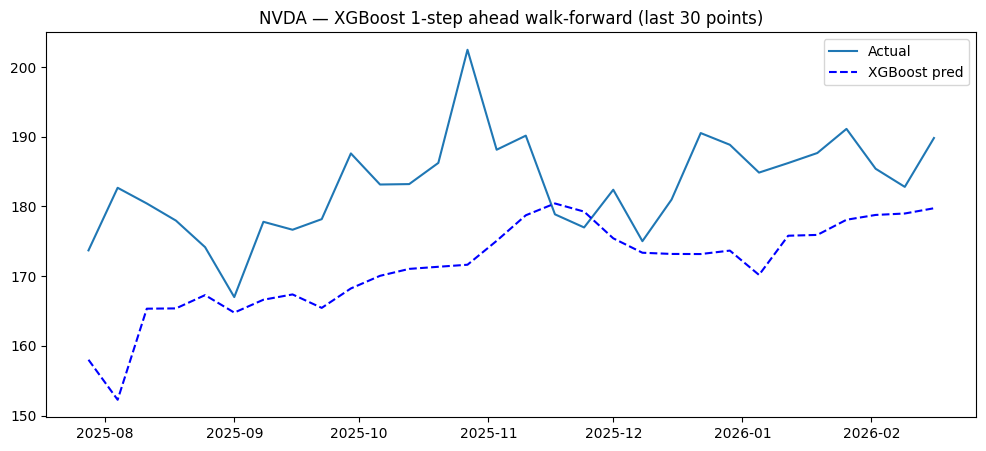

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(xgb_pred.index, xgb_pred["y_true"], label="Actual")
plt.plot(xgb_pred.index, xgb_pred["y_pred"], label="XGBoost pred", color = 'blue', ls='--')
plt.title(f"{SYMBOL} — XGBoost 1-step ahead walk-forward (last {TEST_SIZE} points)")
plt.legend()
plt.show()

In [38]:
from math import sqrt

def backtest_one_step(prices_full: pd.Series, test_size: int, model_factory, min_train: int):
    """
    Walk-forward 1-step backtest with expanding window.
    Same testing method as XGBoost: predict close(t) at each test date using only data before t.
    model_factory: callable that returns a NEW model instance each iteration
    min_train: minimum samples required before first forecast
    """
    preds = []
    
    split_idx = len(prices_full) - test_size
    for i in range(split_idx, len(prices_full)):
        train = prices_full.iloc[:i]
        actual = float(prices_full.iloc[i])
        ts = prices_full.index[i]
        
        if len(train) < min_train:
            continue
        
        model = model_factory()
        model.fit(train)
        fc = model.forecast(periods=1)
        yhat = float(fc["point_forecast"][0])
        
        preds.append({"timestamp": ts, "y_true": actual, "y_pred": yhat})
    
    out = pd.DataFrame(preds).set_index("timestamp")
    return out

Baseline metrics: {'MAE': np.float64(13.580484526367188), 'RMSE': 16.56112026738871, 'MAPE_%': np.float64(7.372577078958222)}
XGBoost metrics: {'MAE': np.float64(11.80613505045573), 'RMSE': 13.658051847600497, 'MAPE_%': np.float64(6.379297582696084)}


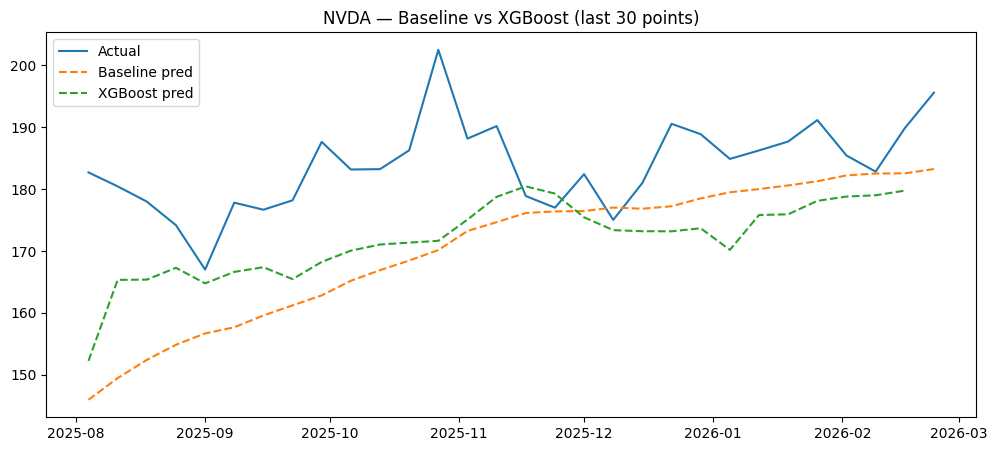

In [39]:
from analytics.forecasting.base import SimpleForecaster

BASELINE_SPAN = 20

baseline_pred = backtest_one_step(
    prices_full=prices,
    test_size=TEST_SIZE,
    model_factory=lambda: SimpleForecaster(span=BASELINE_SPAN, confidence_level=0.95),
    min_train=BASELINE_SPAN
)

print("Baseline metrics:", metrics(baseline_pred))
print("XGBoost metrics:", metrics(xgb_pred))

plot_df = baseline_pred.join(xgb_pred, lsuffix="_base", rsuffix="_xgb")

plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df["y_true_base"], label="Actual")
plt.plot(plot_df.index, plot_df["y_pred_base"], label="Baseline pred", ls='--')
plt.plot(plot_df.index, plot_df["y_pred_xgb"], label="XGBoost pred", ls ='--')
plt.title(f"{SYMBOL} — Baseline vs XGBoost (last {TEST_SIZE} points)")
plt.legend()
plt.show()

In [40]:
OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

xgb_path = OUTDIR / "pred_xgb_weekly_price.parquet"
xgb_pred.reset_index().to_parquet(xgb_path, index=False)
print("Saved:", xgb_path)

Saved: c:\capstone_project_unfc\model\notebooks\artifacts\pred_xgb_weekly_price.parquet


In [41]:
compare = pd.DataFrame([
    {"Model": "Baseline (EWM SimpleForecaster)", **metrics(baseline_pred)},
    {"Model": "XGBoost (enhanced features)", **metrics(xgb_pred)},
]).set_index("Model")

compare

,MAE,RMSE,MAPE_%
Model,,,
Baseline (EWM SimpleForecaster),13.580485,16.561120,7.372577
XGBoost (enhanced features),11.806135,13.658052,6.379298


In [42]:
# --- Fair comparison: Baseline, XGBoost (enhanced), XGBoost (lag-only) ---
# Same testing method for all: predict close(t) at each test date using only data before t (no look-ahead).
# Same TEST_SIZE, same walk-forward (expanding window), same metrics.
# Both XGBoost models: same param_grid, n_iter=40, cv=5, scoring, n_jobs=1, random_state=42.
# Lag-only = no technicals / seasonality / VIX; just historical close lags.
LAG_ONLY_LOOKBACK = 20
XGB_LAG_PARAMS_PATH = REPO_ROOT / "model" / "notebooks" / "artifacts" / "xgb_lag_best_params.json"
RERUN_LAG_TUNING = False

lag_df = pd.DataFrame({"y": prices})
for i in range(1, LAG_ONLY_LOOKBACK + 1):
    lag_df[f"lag_{i}"] = lag_df["y"].shift(i)
lag_df["y_next"] = lag_df["y"].shift(-1)

lag_model_df = lag_df.dropna().copy()
lag_feature_cols = [c for c in lag_model_df.columns if c.startswith("lag_")]

# Same testing as baseline: predict close(t) from features(t-1). Use "y" as close.
X_train_lag = lag_model_df.iloc[0 : -(TEST_SIZE + 1)][lag_feature_cols]
y_train_lag = lag_model_df.iloc[1:-TEST_SIZE]["y"]

if not RERUN_LAG_TUNING and XGB_LAG_PARAMS_PATH.exists():
    with open(XGB_LAG_PARAMS_PATH) as f:
        lag_params = json.load(f)
    print("Loaded saved lag-only params:", lag_params)
else:
    xgb_lag = XGBRegressor(random_state=42, objective="reg:squarederror")
    lag_random_search = RandomizedSearchCV(
        estimator=xgb_lag,
        param_distributions=param_grid,
        n_iter=40,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=1,
        random_state=42,
    )
    lag_random_search.fit(X_train_lag, y_train_lag)
    lag_params = lag_random_search.best_params_
    print("Best lag-only params:", lag_params)
    XGB_LAG_PARAMS_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(XGB_LAG_PARAMS_PATH, "w") as f:
        json.dump(lag_params, f, indent=2)
    print("Saved to", XGB_LAG_PARAMS_PATH)

xgb_lag_pred = walk_forward_xgb(lag_model_df, lag_feature_cols, TEST_SIZE, lag_params, close_col="y")

comparison_df = pd.DataFrame([
    {"Model": "Baseline (EWM SimpleForecaster)", **metrics(baseline_pred)},
    {"Model": "XGBoost (enhanced features)", **metrics(xgb_pred)},
    {"Model": "XGBoost (lag-only)", **metrics(xgb_lag_pred)},
]).set_index("Model")

print("\nFair comparison (same TEST_SIZE, walk-forward, metrics; same XGB tuning):")
comparison_df

Loaded saved lag-only params: {'subsample': 0.8, 'reg_lambda': 2.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Fair comparison (same TEST_SIZE, walk-forward, metrics; same XGB tuning):


,MAE,RMSE,MAPE_%
Model,,,
Baseline (EWM SimpleForecaster),13.580485,16.561120,7.372577
XGBoost (enhanced features),11.806135,13.658052,6.379298
XGBoost (lag-only),17.933443,20.855395,9.766603
